#### Import packages

In [1]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn') 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import random
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import torch.utils.data
import torch.utils.data as data_utils
from collections import OrderedDict

seed = 0
# random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)
from utils_diff_ch import *

#### Load and Prepare Data

In [4]:
data = pd.read_json('./Data/train.json')
test = pd.read_json('./Data/test.json')

In [5]:
data['band_1'] = data['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

test['band_1'] = test['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
test['band_2'] = test['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')

In [6]:
# Impute missing incidence angles
data_impute = data.dropna(axis=0, how='any')
data_impute_b1 = np.array([im.reshape(75*75) for im in data_impute.loc[:,'band_1']])
data_impute_b2 = np.array([im.reshape(75*75) for im in data_impute.loc[:,'band_2']])
data_impute_X = np.hstack(np.array((data_impute_b1, data_impute_b2, data_impute[['is_iceberg']])))
data_impute_y = np.array(data_impute[['inc_angle']])

data_impute_prec = data[~data.index.isin(data_impute.index.values)]
data_impute_b1_prec = np.array([im.reshape(75*75) for im in data_impute_prec.loc[:,'band_1']])
data_impute_b2_prec = np.array([im.reshape(75*75) for im in data_impute_prec.loc[:,'band_2']])
data_impute_X_prec = np.hstack(np.array((data_impute_b1_prec, data_impute_b2_prec, data_impute_prec[['is_iceberg']])))

modelImpute = LinearRegression()
modelImpute = modelImpute.fit(data_impute_X, data_impute_y)
data_impute_prec['inc_angle'] = modelImpute.predict(data_impute_X_prec)

data.loc[data_impute_prec.index] = data_impute_prec

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
def scale_range (input_, min_, max_):
    input_ += -(np.min(input_))
    input_ /= np.max(input_) / (max_ - min_)
    input_ += min_
    return input_

In [8]:
train, val = train_test_split(data, test_size=0.2, random_state=42)
band_1_tr = np.concatenate([im for im in train['band_1']]).reshape(-1, 75, 75)
band_2_tr = np.concatenate([im for im in train['band_2']]).reshape(-1, 75, 75)
X_train = np.stack((band_1_tr, band_2_tr), axis=1)
X_train = [X_train, np.array(train['inc_angle']).reshape((len(train), 1))]

band_1_val = np.concatenate([im for im in val['band_1']]).reshape(-1, 75, 75)
band_2_val = np.concatenate([im for im in val['band_2']]).reshape(-1, 75, 75)
X_val = np.stack((band_1_val, band_2_val), axis=1)
X_val = [X_val, np.array(val['inc_angle']).reshape((len(val), 1))]

band_1_test = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
band_2_test = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
# band_3_test = scale_range(band_1_test/band_2_test, -1, 1)
rgb = np.stack((band_1_test, band_2_test), axis=1)
X_test = [rgb, np.array(test['inc_angle']).reshape((len(test), 1))]

y_train = train['is_iceberg'].values.astype(np.float32)
y_val = val['is_iceberg'].values.astype(np.float32)

#### PyTorch Model

In [9]:
# Hyper Parameters
width = 75
height = 75
channels = 2
padding = 0
batch_size = 32

In [10]:
# Data Loader (Input Pipeline)
class icebergDataset(data_utils.Dataset):
    """Iceberg-Ship dataset."""

    def __init__(self, X, y=None, transform=None):
        self.X_images = X[0]
        self.X_angles = torch.from_numpy(X[1]).float()
        if y!=None:
            self.y = torch.from_numpy(y.reshape((len(y),1))).float()
        else:
            self.y=None
        self.transform = transform

    def __len__(self):
        return len(self.X_images)

    def __getitem__(self, idx):
        im = self.X_images[idx]
        if self.transform:
#             if np.random.random() < 0.2:
#                 im = cv2.blur(im, (2,2))
            im = randomErodeDilate(im, u=0.2)
            im = randomZoomOut(im, u=0.4)
            im = randomNoisy(im, u=0.2)
            im = randomShift(im, u=0.2)
            im = randomRotation(im, u=0.2)
        try:
            if self.y==None:
                return [torch.from_numpy(im).float(), self.X_angles[idx]]
        except:
            pass
            
        return [torch.from_numpy(im).float(), self.X_angles[idx], self.y[idx]]

In [11]:
def save_checkpoint(state, is_best, filename='./Models/checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, './Models/model_best.pth.tar')

In [12]:
train_dataset = icebergDataset(X_train, y_train, transform=True)
val_dataset = icebergDataset(X_val, y_val)
test_dataset = icebergDataset(X_test)

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [13]:
act = nn.PReLU()
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.batch = nn.BatchNorm2d(channels)
        self.batch1D = nn.BatchNorm1d(1)
        self.layer1 = nn.Sequential(
            nn.Conv2d(channels, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.Conv2d(18, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(18, 36, kernel_size=3, padding=padding),
            nn.BatchNorm2d(36),
            act,
            nn.Conv2d(36, 54, kernel_size=3, padding=padding),
            nn.BatchNorm2d(54),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(54, 72, kernel_size=2, padding=padding),
            nn.BatchNorm2d(72),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(72, 144, kernel_size=2, padding=padding),
            nn.BatchNorm2d(144),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(144, 54, kernel_size=2, padding=padding),
            nn.BatchNorm2d(54),
            act,
            nn.Dropout(0))
        self.layer6 = nn.Sequential(
            nn.Conv2d(54, 1, kernel_size=2, padding=padding),
#             nn.BatchNorm2d(2),
#             act,
            nn.Dropout(0))
        self.layer_shallow = nn.Sequential(
            nn.Conv2d(channels, 9, kernel_size=3, padding=padding, stride=2),
            nn.BatchNorm2d(9),
            act,
            nn.Conv2d(9, 12, kernel_size=3, padding=padding),
            nn.BatchNorm2d(12),
            act,
            nn.Conv2d(12, 15, kernel_size=3, padding=padding),
            nn.BatchNorm2d(15),
            act,
            nn.Conv2d(15, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            act,

            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.fc1 = nn.Sequential(
            nn.Linear((3*3*144), 512),
            act,
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(512, 196),
            act,
            nn.Dropout(0.5))
        self.fc3 = nn.Linear(196, 1)
        self.sig = nn.Sigmoid()
        
        
    def forward(self, x_im, x_angle):
#         x_angle_ch_sin = x_im*torch.sin(x_angle).expand(75,75,x_angle.size(0),2).contiguous().view(x_angle.size(0), 2, height, width)
#         x_angle_ch_cos = x_im*torch.sin(x_angle).expand(75,75,x_angle.size(0),2).contiguous().view(x_angle.size(0), 2, height, width)
#         x_im = torch.cat([x_im, x_angle_ch_sin, x_angle_ch_cos], dim=1)
        x_angle = self.batch1D(x_angle)
        x_im = self.batch(x_im)
        out = self.layer1(x_im)
#         out_skip = self.layer_shallow(x_im)
        out = self.layer2(out)
#         out = torch.cat([out, out_skip], dim=1)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)        
        out = F.max_pool2d(out, kernel_size=out.size()[2:])
        out = out.view(out.size(0), -1)
#         out = out.view(out.size(0), -1)
#         out_shallow = self.layer_shallow(x_im)
#         out_shallow  = F.max_pool2d(out_shallow, kernel_size=out_shallow.size()[2:])
#         out_shallow = out_shallow.view(out_shallow.size(0), -1)
#         out = torch.cat([out, x_angle], dim=1)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         out = self.fc3(out)
        return out

In [14]:
def weight_init(m): 
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal(m.weight.data)

In [13]:
writer = SummaryWriter()
iceNet = net()
iceNet.apply(weight_init).cuda()

net (
  (batch): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True)
  (batch1D): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
  (layer1): Sequential (
    (0): Conv2d(2, 18, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.01)
    (3): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
    (5): LeakyReLU (0.01)
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Dropout (p = 0.2)
  )
  (layer2): Sequential (
    (0): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.01)
    (3): Conv2d(36, 54, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True)
    (5): LeakyReLU (0.01)
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Dropout (p = 0.2)
  )
  (layer3): Sequential (
    (0

In [14]:
num_epochs = 200
batch_size = 32
learning_rate = 0.001

In [15]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    for features, features_angle, labels in loader:
        features = features.cuda()
        labels = labels.cuda()
        features_angle = features_angle.cuda()
        features = Variable(features, volatile=True)
        features_angle = Variable(features_angle, volatile=True)
        labels = Variable(labels, volatile=True)
        outputs = iceNet(features, features_angle)
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        
    return np.mean(loss).data[0], (100 * correct / total)

In [17]:
# Train the Model
best_prec1 = 1
for epoch in range(num_epochs):
    epoch_train_loss = []
    for i, (features, features_angle, labels) in enumerate(train_loader):
        iceNet.train()
        features = features.cuda()
        labels = labels.cuda()
        features = Variable(features).float()
        features_angle = Variable(features_angle).cuda()
        labels = Variable(labels).long()
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = iceNet(features, features_angle)
        writer.add_graph(iceNet, outputs)
#         writer.add_histogram('hist_fc1', iceNet.fc1[0].weight.data.cpu().numpy(), i)
#         writer.add_histogram('hist_fc2', iceNet.fc2[0].weight.data.cpu().numpy(), i)
#         writer.add_histogram('hist_fc3', iceNet.fc3.weight.data.cpu().numpy(), i)
        loss = criterion(outputs, labels)
        epoch_train_loss.append(loss)
        loss.backward()
        optimizer.step()
        
    prec1 = accuracy(val_loader)[0]
    print ('Epoch [%d/%d] \nTraining Loss: %.4f' % (epoch+1, num_epochs, np.mean(epoch_train_loss).data[0]))
    print('Validation Loss: %.4f, Accuracy: %.2f%%' % accuracy(val_loader))
    
    is_best = prec1 < best_prec1
    best_prec1 = min(prec1, best_prec1)
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'state_dict': iceNet.state_dict(),
#         'best_prec1': best_prec1,
#         'optimizer' : optimizer.state_dict(),
#     }, is_best)

print(best_prec1)
# export scalar data to JSON for external processing
writer.close()

Epoch [1/200] 
Training Loss: 0.3002
Validation Loss: 0.2277, Accuracy: 90.97%
Epoch [2/200] 
Training Loss: 0.3804
Validation Loss: 0.2318, Accuracy: 87.54%
Epoch [3/200] 
Training Loss: 0.3302
Validation Loss: 0.2344, Accuracy: 89.10%
Epoch [4/200] 
Training Loss: 0.3026
Validation Loss: 0.2215, Accuracy: 90.97%
Epoch [5/200] 
Training Loss: 0.3258
Validation Loss: 0.2390, Accuracy: 87.85%
Epoch [6/200] 
Training Loss: 0.3210
Validation Loss: 0.2350, Accuracy: 89.10%
Epoch [7/200] 
Training Loss: 0.3032
Validation Loss: 0.2308, Accuracy: 89.41%
Epoch [8/200] 
Training Loss: 0.2951
Validation Loss: 0.2359, Accuracy: 88.79%
Epoch [9/200] 
Training Loss: 0.3216
Validation Loss: 0.2380, Accuracy: 89.72%
Epoch [10/200] 
Training Loss: 0.3286
Validation Loss: 0.2335, Accuracy: 88.47%
Epoch [11/200] 
Training Loss: 0.2965
Validation Loss: 0.2408, Accuracy: 88.16%
Epoch [12/200] 
Training Loss: 0.2914
Validation Loss: 0.2420, Accuracy: 89.41%
Epoch [13/200] 
Training Loss: 0.3219
Validation 

Epoch [104/200] 
Training Loss: 0.2976
Validation Loss: 0.2401, Accuracy: 89.72%
Epoch [105/200] 
Training Loss: 0.3239
Validation Loss: 0.2344, Accuracy: 89.72%
Epoch [106/200] 
Training Loss: 0.2943
Validation Loss: 0.2142, Accuracy: 90.65%
Epoch [107/200] 
Training Loss: 0.2780
Validation Loss: 0.2247, Accuracy: 90.34%
Epoch [108/200] 
Training Loss: 0.2887
Validation Loss: 0.2435, Accuracy: 89.72%
Epoch [109/200] 
Training Loss: 0.2862
Validation Loss: 0.2414, Accuracy: 89.10%
Epoch [110/200] 
Training Loss: 0.3088
Validation Loss: 0.2233, Accuracy: 90.03%
Epoch [111/200] 
Training Loss: 0.3404
Validation Loss: 0.2375, Accuracy: 89.41%
Epoch [112/200] 
Training Loss: 0.3013
Validation Loss: 0.2276, Accuracy: 89.72%
Epoch [113/200] 
Training Loss: 0.2865
Validation Loss: 0.2269, Accuracy: 90.34%
Epoch [114/200] 
Training Loss: 0.2754
Validation Loss: 0.2344, Accuracy: 89.72%
Epoch [115/200] 
Training Loss: 0.2823
Validation Loss: 0.2350, Accuracy: 88.47%
Epoch [116/200] 
Training Lo

In [44]:
print("=> loading checkpoint")
best_model = torch.load('./Models/model_best.pth.tar')
print('best_prec1 = ', best_model['best_prec1'])
iceNet.load_state_dict(best_model['state_dict'])
optimizer.load_state_dict(best_model['optimizer'])

=> loading checkpoint
best_prec1 =  0.2147292047739029


In [129]:
# Predict
iceNet.eval()
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
results = []
for features, features_angle in test_loader:
    iceNet.eval()
    features = Variable(features, volatile=True).cuda()
    features_angle = Variable(features_angle, volatile=True).cuda()
    outputs = F.softmax(iceNet(features, features_angle))
#     outputs = iceNet(features, features_angle)

    results.append(outputs.data[0][1])

In [126]:
sum(y_train>0.5)/len(y_train)

0.45908028059236167

In [130]:
sum(np.array(results)>0.5)/len(results)

0.30282526115859448

In [132]:
sub = pd.read_csv('./Data/sample_submission.csv')

In [133]:
sub['is_iceberg'] = results

In [135]:
sub.to_csv('./Submissions/sub_30Oct_val_1631.csv', index=False)

#### KFold

In [15]:
def scale_test_range (input_, train_min, train_max, min_, max_):
    input_ += -(train_min)
    input_ /= train_max / (max_ - min_)
    input_ += min_
    return input_

def std_test_range (input_, mean, sd):
    input_ -= mean
    input_ /= sd
    return input_

In [16]:
def weight_init(m): 
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal(m.weight.data)

In [17]:
band_1_KF = np.concatenate([im for im in data['band_1']]).reshape(-1, 75, 75)
band_2_KF = np.concatenate([im for im in data['band_2']]).reshape(-1, 75, 75)
# band_3_KF = scale_range(band_1_KF/band_2_KF, -1, 1)
X_KF = np.stack((band_1_KF, band_2_KF), axis=1)
X_KF = [X_KF, np.array(data['inc_angle']).reshape((len(data), 1))]

# X_test[0] = scale_test_range(X_test[0], train_min, train_max, -1, 1)
y_KF = data['is_iceberg'].values.astype(np.float32)

In [18]:
def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    predicted_val = []
    for features, features_angle, labels in loader:
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        labels = Variable(labels, volatile=True).cuda().float()
        outputs = iceNet(features, features_angle)
        predicted_val.append(outputs.data[:].cpu().numpy())
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        predicted = (F.sigmoid(outputs).data>0.5)
        total += labels.size(0)
        correct += (predicted == labels.byte().data).sum()
    return np.mean(loss).data[0], (100 * correct / total), np.concatenate(predicted_val)

In [19]:
num_epochs = 300
batch_size = 32
learning_rate = 0.001

In [20]:
kfold = 5
kfold_scores = []

test_dataset = icebergDataset(X_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

results = []
fold_predictions = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
    X_train_KF, X_valid_KF = [X_KF[0][train_index], X_KF[1][train_index]], [X_KF[0][test_index], X_KF[1][test_index]]
    y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]
    
    # Define model
    iceNet = net().apply(weight_init).cuda()
    
    # Loss and Optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)
    
    # Data Loader
    train_dataset_KF = icebergDataset(X_train_KF, y_train_KF, transform=True)
    val_dataset_KF = icebergDataset(X_valid_KF, y_valid_KF)

    train_loader_KF = torch.utils.data.DataLoader(dataset=train_dataset_KF, batch_size=batch_size, shuffle=True)
    val_loader_KF = torch.utils.data.DataLoader(dataset=val_dataset_KF, batch_size=batch_size, shuffle=False)
    
    print('Fold [%d/%d]' % (i+1, kfold))
    # Train
    best_prec1 = 1
    for epoch in range(num_epochs):
        epoch_train_loss = []
        for idx, (features, features_angle, labels) in enumerate(train_loader_KF):
            iceNet.train()
            features = Variable(features).cuda()
            features_angle = Variable(features_angle).cuda()
            labels = Variable(labels).cuda().float()
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = iceNet(features, features_angle)
            loss = criterion(outputs, labels)
            epoch_train_loss.append(loss)
            loss.backward()
            optimizer.step()

        acc = accuracy(val_loader_KF)
        prec1 = acc[0]

        # Save best model
        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        if is_best:
            best_fold_predictions = acc[2]
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': iceNet.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best, filename='./Models/v1Nov_v1/model_fold_'+str(i+1)+'.pth.tar')
        
    print('Val Score : %f' % (best_prec1))
    fold_predictions.append(best_fold_predictions)
    kfold_scores.append(best_prec1)
    # Load best model
    best_model = torch.load('./Models/v1Nov_v1/model_fold_'+str(i+1)+'.pth.tar')
    iceNet.load_state_dict(best_model['state_dict'])
    optimizer.load_state_dict(best_model['optimizer'])
    
    # Predict
    iceNet.eval()
    
    results_fold = []
    for features, features_angle in test_loader:
        iceNet.eval()
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        outputs = F.sigmoid(iceNet(features, features_angle))
    #     outputs = iceNet(features, features_angle)

        results_fold.append(outputs.data.cpu().numpy()[0][0])        
    
    results.append(np.array(results_fold))

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Fold [1/5]
Val Score : 0.167386
Fold [2/5]
Val Score : 0.155855
Fold [3/5]
Val Score : 0.209318
Fold [4/5]
Val Score : 0.162282
Fold [5/5]
Val Score : 0.216528


In [21]:
np.array(kfold_scores).mean()

0.18227382600307465

In [43]:
np.array(sub['is_iceberg']<0.5).sum()

5400

In [45]:
results

[array([ 0.0015132 ,  0.75929737,  0.09932296, ...,  0.00393689,
         0.99953043,  0.96022266], dtype=float32),
 array([ 0.00734197,  0.47810149,  0.08085983, ...,  0.00211423,
         0.99917287,  0.73575026], dtype=float32),
 array([  7.57008344e-02,   5.08652568e-01,   5.50010882e-05, ...,
          1.26925390e-03,   9.98471439e-01,   7.44244933e-01], dtype=float32),
 array([ 0.00498175,  0.43639177,  0.1462035 , ...,  0.00347645,
         0.99849415,  0.83130521], dtype=float32),
 array([  3.52827716e-04,   6.19318664e-01,   1.10552525e-02, ...,
          3.54599464e-03,   9.92131293e-01,   8.65881383e-01], dtype=float32)]

In [47]:
sub_num = 32
os.makedirs("./Models/Sub "+str(sub_num))
np.savetxt("./Models/Sub "+str(sub_num)+"/results.csv", np.array(results), delimiter=",")
np.savetxt("./Models/Sub "+str(sub_num)+"/cv_fold_results.csv", np.concatenate(fold_predictions), delimiter=",")
sub = pd.read_csv('./Data/sample_submission.csv')
sub['is_iceberg'] = np.array(results).mean(axis=0)
sub.to_csv('./Submissions/Sub '+str(sub_num)+' - 5-fold _ Val-1823.csv', index=False)

In [3]:
sub = pd.read_csv('./Data/sample_submission.csv')

In [4]:
sub1 = pd.read_csv('./Submissions/Sub 3 - 5 fold _ Val - 0.1504.csv')['is_iceberg']
sub2 = pd.read_csv('./Submissions/Sub 4 - 10-fold _ Val-1269.csv')['is_iceberg']
sub3 = pd.read_csv('./Submissions/Sub 5 - 5-fold _ Val-1538.csv')['is_iceberg']
sub4 = pd.read_csv('./Submissions/Sub 6 - 5-fold _ Val-1480.csv')['is_iceberg']
sub5 = pd.read_csv('./Submissions/Sub 8 - 5-fold _ Val-1479.csv')['is_iceberg']
sub6 = pd.read_csv('./Submissions/Sub 16 - 5-fold _ Val-1422.csv')['is_iceberg']

In [5]:
results = 1/np.mean((1/np.array(sub1), 1/np.array(sub3),
                   1/np.array(sub4), 1/np.array(sub2), 1/np.array(sub6), 1/np.array(sub5)), axis=0)
sub['is_iceberg'] = np.array(results)
sub.to_csv('./Submissions/Sub 18 - Ensemble_3_4_5_6_8_16 - Harmonic Mean.csv', index=False)

#### Error Analysis

In [11]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

count    1471.000000
mean       39.268707
std         3.839744
min        24.754600
25%        36.106100
50%        39.501500
75%        42.559100
max        45.937500
Name: inc_angle, dtype: float64


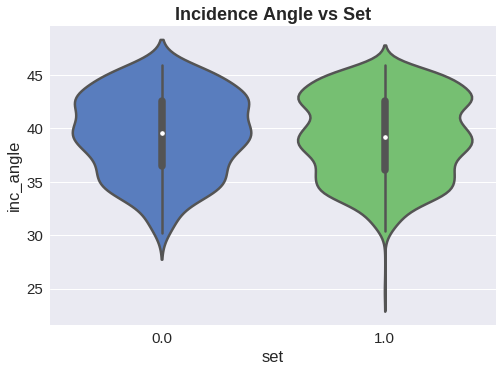

count    1471.000000
mean       39.268707
std         3.839744
min        24.754600
25%        36.106100
50%        39.501500
75%        42.559100
max        45.937500
Name: inc_angle, dtype: float64


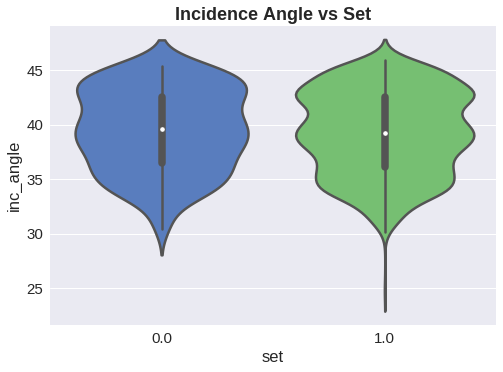

count    1471.000000
mean       39.268707
std         3.839744
min        24.754600
25%        36.106100
50%        39.501500
75%        42.559100
max        45.937500
Name: inc_angle, dtype: float64


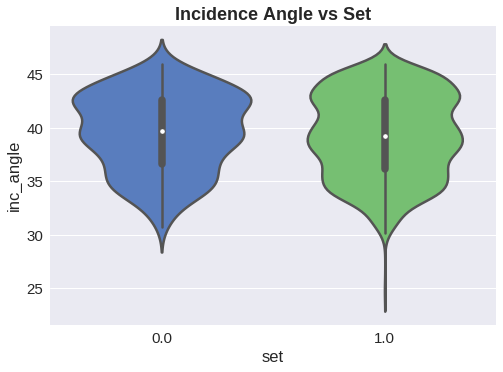

count    1471.000000
mean       39.268707
std         3.839744
min        24.754600
25%        36.106100
50%        39.501500
75%        42.559100
max        45.937500
Name: inc_angle, dtype: float64


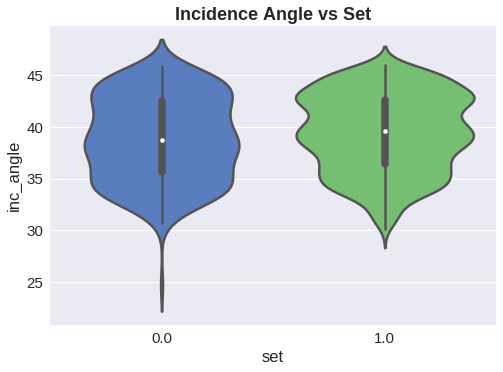

count    1471.000000
mean       39.268707
std         3.839744
min        24.754600
25%        36.106100
50%        39.501500
75%        42.559100
max        45.937500
Name: inc_angle, dtype: float64


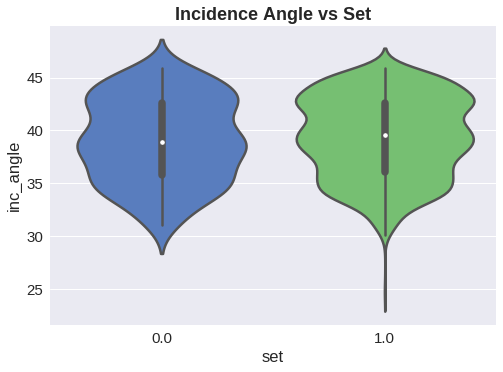

In [31]:
kfold = 5
kfold_scores = []

test_dataset = icebergDataset(X_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

results = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
    X_train_KF, X_valid_KF = [X_KF[0][train_index], X_KF[1][train_index]], [X_KF[0][test_index], X_KF[1][test_index]]
    y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]
    
    data = pd.DataFrame(np.hstack((np.vstack((X_valid_KF[1], X_train_KF[1])),
                                       np.concatenate((np.zeros((len(X_valid_KF[1]))), np.ones((len(X_train_KF[1])))),
                                                      axis=0).reshape(1604,1))),
                        columns=['inc_angle', 'set'])
    sns.violinplot(x='set', y='inc_angle', data=data)
    plt.title('Incidence Angle vs Set', fontweight='bold')
    print(data['inc_angle'].describe())
    plt.show()

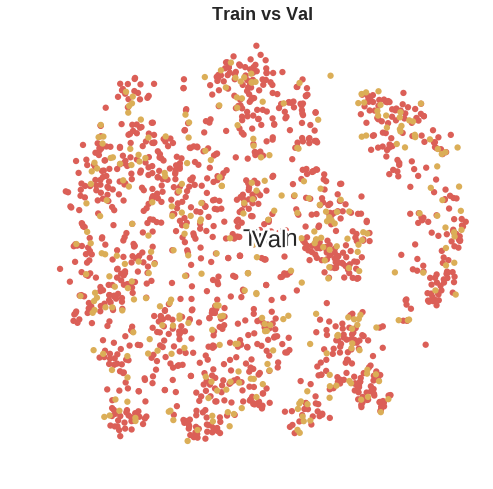

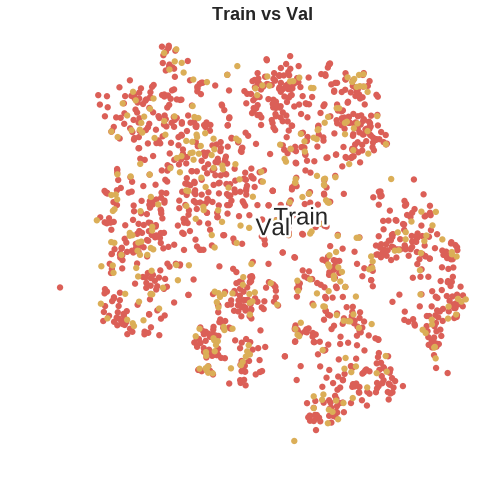

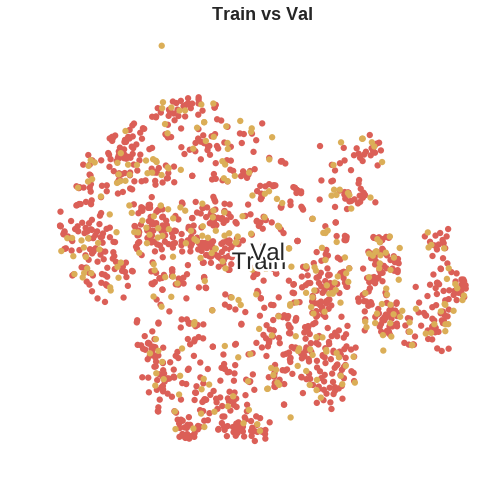

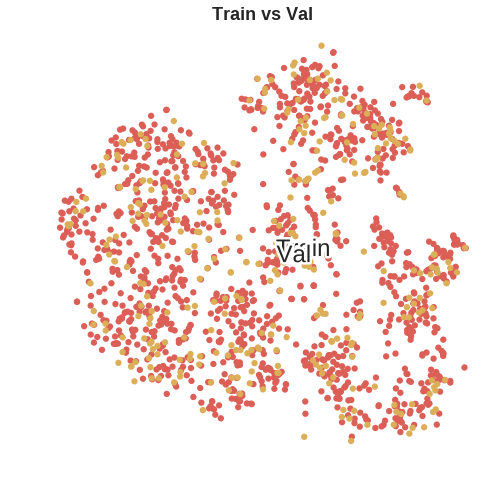

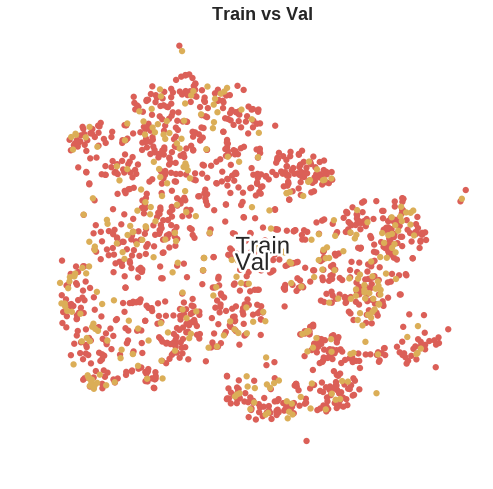

In [60]:
kfold = 5
kfold_scores = []

test_dataset = icebergDataset(X_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

results = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
    X_train_KF, X_valid_KF = [X_KF[0][train_index], X_KF[1][train_index]], [X_KF[0][test_index], X_KF[1][test_index]]
    y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]
    
#     X_train = np.multiply(X_valid_KF[0],np.sin(X_valid_KF[1])[:, np.newaxis, np.newaxis])
#     X_train = np.concatenate((X_valid_KF[0], (X_valid_KF[0][:,0,:,:]/X_valid_KF[0][:,1,:,:]).reshape(len(X_valid_KF[0]),1,75,75)),axis=1)

    X_train = np.vstack((X_train_KF[0], X_valid_KF[0]))
#     y_train = y_valid_KF
    y_train = np.vstack((np.zeros((len(X_train_KF[0]),1)), np.ones((len(X_valid_KF[0]),1)))).reshape((len(X_train)))
    X_train_tsne = np.vstack([X_train[np.where(y_train==i)]
               for i in range(2)]).reshape((len(X_train), 2*75*75))
    y_train_tsne = y_train.copy()
    y_train_tsne = y_train_tsne[~np.isnan(X_train_tsne).any(axis=1)]
    X_train_tsne = X_train_tsne[~np.isnan(X_train_tsne).any(axis=1),:]
    digits_proj_X_train = TSNE(random_state=seed).fit_transform(X_train_tsne)
    scatter(digits_proj_X_train, y_train_tsne, class_list=['Train', 'Val'])
    plt.title('Train vs Val', fontweight='bold')
    plt.show()

In [32]:
def scatter(x, colors, class_list = ['ship', 'iceberg']):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i, text in enumerate(class_list):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(text), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts